In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import numpy as np

## Read all files then combine

In [2]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for i in range(1,11):
    train_input_path = f"fraud_detection/DataminingContest2009.Task1.CV{i}.Train.Inputs"
    train_target_path = f"fraud_detection/DataminingContest2009.Task1.CV{i}.Train.Targets"
    test_input_path = f"fraud_detection/DataminingContest2009.Task1.CV{i}.Test.Inputs"
    test_target_path = f"fraud_detection/DataminingContest2009.Task1.CV{i}.Test.Targets"
    df_train_input = pd.read_csv(train_input_path)
    df_train_target = pd.read_csv(train_target_path)
    df_test_input = pd.read_csv(test_input_path)
    df_test_target = pd.read_csv(test_target_path)
    
    
    df_train_batch = df_train_input.merge(df_train_target, how='left', left_index=True, right_index=True)
    df_test_batch = df_test_input.merge(df_test_target, how='left', left_index=True, right_index=True)
    df_train_batch.rename(columns={'0': 'is_fraud'}, inplace=True)
    df_test_batch.rename(columns={'0': 'is_fraud'}, inplace=True)
    
    df_train = pd.concat([df_train, df_train_batch], axis=0, ignore_index=True)
    df_test = pd.concat([df_test, df_test_batch], axis=0, ignore_index=True)

df_train.to_csv('fraud_detection/train_combined.csv', index=False)
df_test.to_csv('fraud_detection/test_combined.csv', index=False)

FileNotFoundError: ignored

In [ ]:
print("df_train")
# print("expected length: {}".format(df_train_len))
print("actual length: {}".format(len(df_train)))
print(df_train.head())
df_train.info()

print("df_test")
# print("expected length: {}".format(df_test_len))
print("actual length: {}".format(len(df_test)))
print(df_test.head())
df_test.info()

df_train
actual length: 852138
   amount  hour1 state1  zip1  field1  ... flag2  flag3  flag4  flag5  is_fraud
0   12.95      0     CA   925       3  ...     1      1      0      1       0.0
1   11.01      0     CA   925       3  ...     1      1      0      1       0.0
2   38.85      0     CA   928       3  ...     0      0      0      1       0.0
3   25.90      0     NJ    77       0  ...     1      1      0      1       0.0
4   12.95      0     CA   945       3  ...     1      0      0      1       0.0

[5 rows x 20 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852138 entries, 0 to 852137
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   amount      852138 non-null  float64
 1   hour1       852138 non-null  int64  
 2   state1      852138 non-null  object 
 3   zip1        852138 non-null  int64  
 4   field1      852138 non-null  int64  
 5   domain1     852129 non-null  object 
 6   field2      85

### Read data

In [ ]:
df_train = pd.read_csv('fraud_detection/train_combined.csv')
df_test = pd.read_csv('fraud_detection/test_combined.csv')

### Check missing value

In [ ]:
def top_missing_cols(df, n=10, threshold=80):
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > threshold].shape[0]} columns with missing percent values than {threshold}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [ ]:
top_missing_cols(df_train)

There are 2 columns in this dataset with missing values.
There are 0 columns with missing percent values than 80%


,col,missing_percent
0,is_fraud,0.001174
1,domain1,0.001056
2,field4,0.000000
3,flag5,0.000000
4,flag4,0.000000
5,flag3,0.000000
6,flag2,0.000000
7,indicator2,0.000000
8,indicator1,0.000000
9,field5,0.000000


Row dengan missing target dihapus karena persentase kecil

In [ ]:
df_train = df_train.dropna(subset=['is_fraud'])
df_train['is_fraud'] = df_train['is_fraud'].astype('int64')

Row dengan missing target dihapus karena persentase kecil

In [ ]:
top_missing_cols(df_test)

There are 2 columns in this dataset with missing values.
There are 0 columns with missing percent values than 80%


,col,missing_percent
0,is_fraud,0.010562
1,domain1,0.001056
2,field4,0.000000
3,flag5,0.000000
4,flag4,0.000000
5,flag3,0.000000
6,flag2,0.000000
7,indicator2,0.000000
8,indicator1,0.000000
9,field5,0.000000


Row dengan missing target dihapus karena persentase kecil

In [ ]:
df_test = df_test.dropna(subset=['is_fraud'])
df_test['is_fraud'] = df_test['is_fraud'].astype('int64')

In [ ]:
df_train['is_fraud'].value_counts()

0    833282
1     18846
Name: is_fraud, dtype: int64

# EDA

## Target Distribution

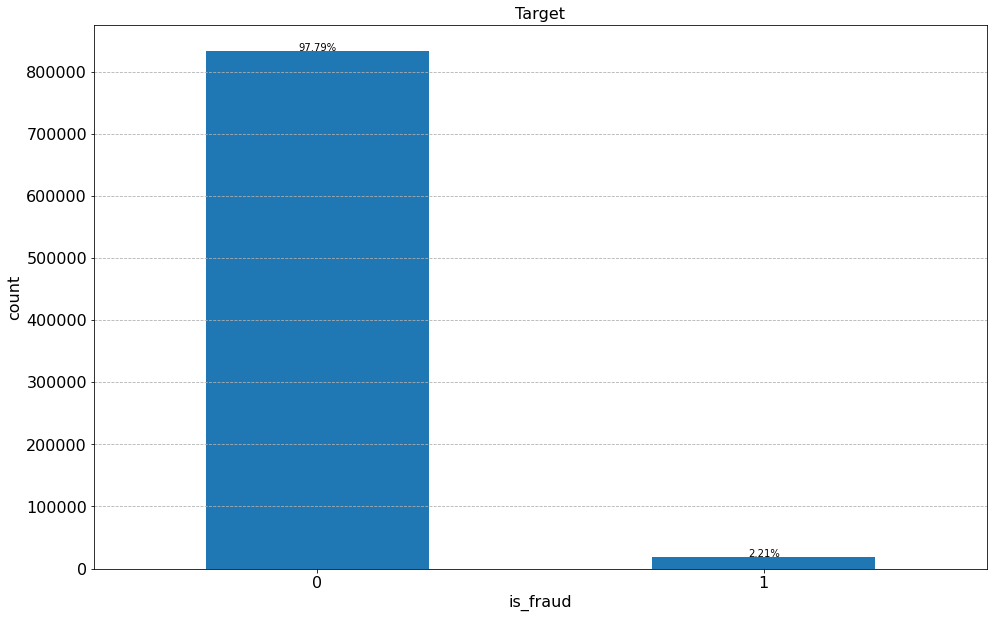

In [ ]:
params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16,}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(16,10))
ax = df_train['is_fraud'].value_counts().plot(kind='bar', title='Target', xlabel='is_fraud', ylabel='count',rot=0)
ax.grid(axis='y', linestyle='--')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height / len(df_train):.2%}', (x + width/2, y + height), ha='center')


97.78% transactions are not fraud and 2.21% transactions are fraud. We will choose AUC ROC as a metric because of imbalance data. Accuracy will fail in scenario where model predict all transactions are not fraud.

## Data Dispersion

In [ ]:
df_train.nunique()

amount           88
hour1            24
state1           53
zip1            899
field1            5
domain1        9809
field2            2
hour2            24
flag1             2
total            88
field3        15786
field4           38
field5           26
indicator1        2
indicator2        2
flag2             2
flag3             2
flag4             2
flag5            36
is_fraud          2
dtype: int64

In [ ]:
df_train[['amount','field3','field4','field5','flag5']].describe(include=np.number)

,amount,field3,field4,field5,flag5
count,852128.000000,852128.000000,852128.000000,852128.000000,852128.000000
mean,25.635157,714.526382,13.984187,1.375682,6.176705
std,14.190429,3919.326971,6.516825,2.423943,102.977564
min,0.000000,-32265.000000,6.000000,0.000000,0.000000
25%,12.950000,-1551.000000,8.000000,0.000000,1.000000
50%,25.900000,1455.000000,12.000000,0.000000,1.000000
75%,38.850000,3598.000000,19.000000,2.000000,1.000000
max,95.400000,8193.000000,46.000000,26.000000,3278.000000


## Transaction Hour

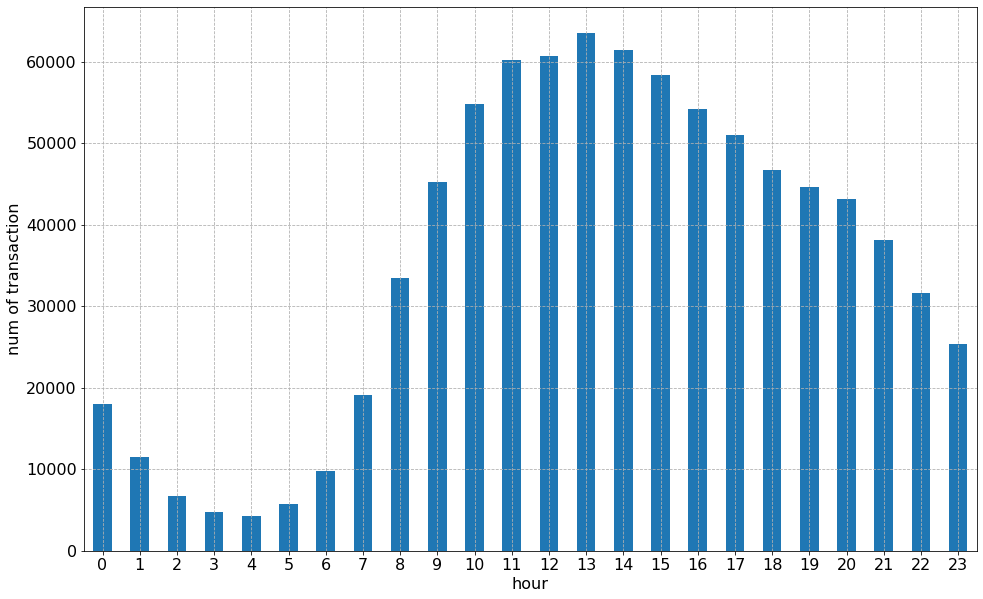

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax = df_train['hour1'].value_counts().sort_index().plot(kind='bar', rot=0, xlabel="hour", ylabel="num of transaction")
ax.grid( linestyle='--')

Num of Transaction has a peak at 13.

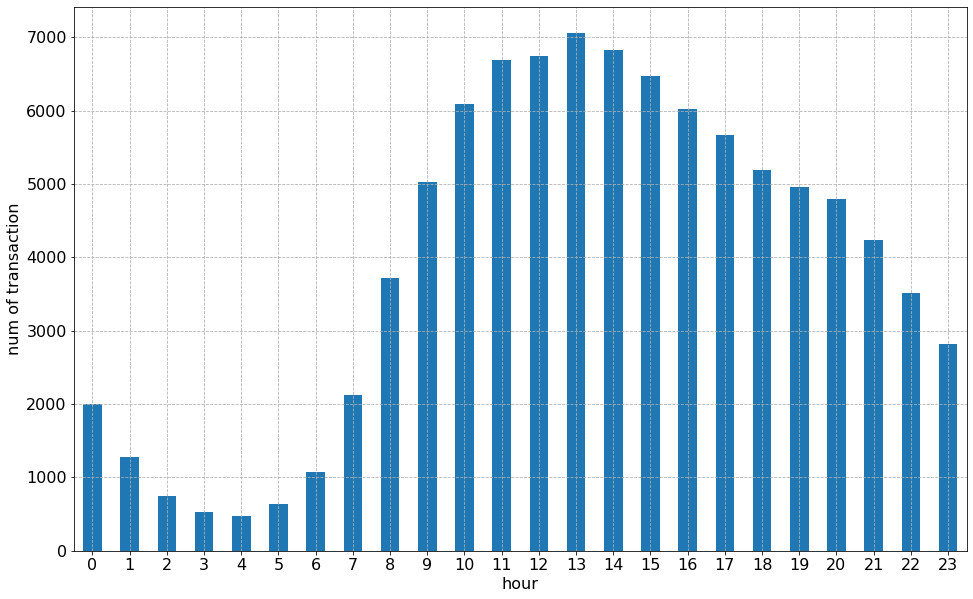

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax = df_test['hour1'].value_counts().sort_index().plot(kind='bar', rot=0, xlabel="hour", ylabel="num of transaction")
ax.grid( linestyle='--')

Same as train data, test's Num of Transaction has a peak at 13.

## Transaction Amount

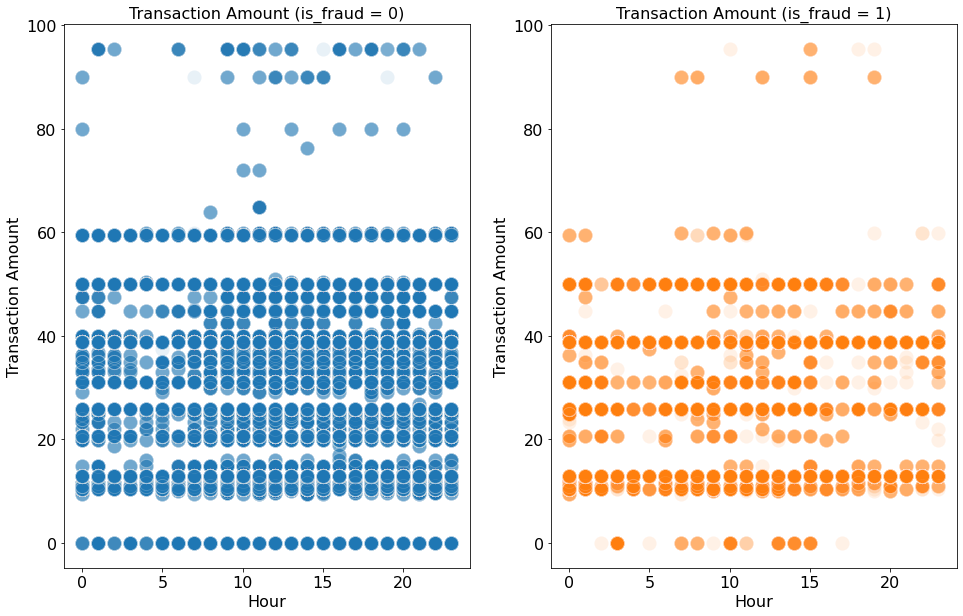

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,10))

df = df_train.loc[df_train['is_fraud'] == 0, ['hour1', 'amount', 'is_fraud']]
ax[0].scatter(x=df['hour1'], y=df['amount'], c='tab:blue', edgecolors='white', s=200, alpha=.1)
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Transaction Amount')
ax[0].set_title('Transaction Amount (is_fraud = 0)')

df = df_train.loc[df_train['is_fraud'] == 1, ['hour1', 'amount', 'is_fraud']]
ax[1].scatter(x=df['hour1'], y=df['amount'], c='tab:orange', edgecolors='white', s=200, alpha=.1)
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Transaction Amount')
ax[1].set_title('Transaction Amount (is_fraud = 1)')

plt.show()

No outlier found in Transaction Amount - Hour.

## Transaction State

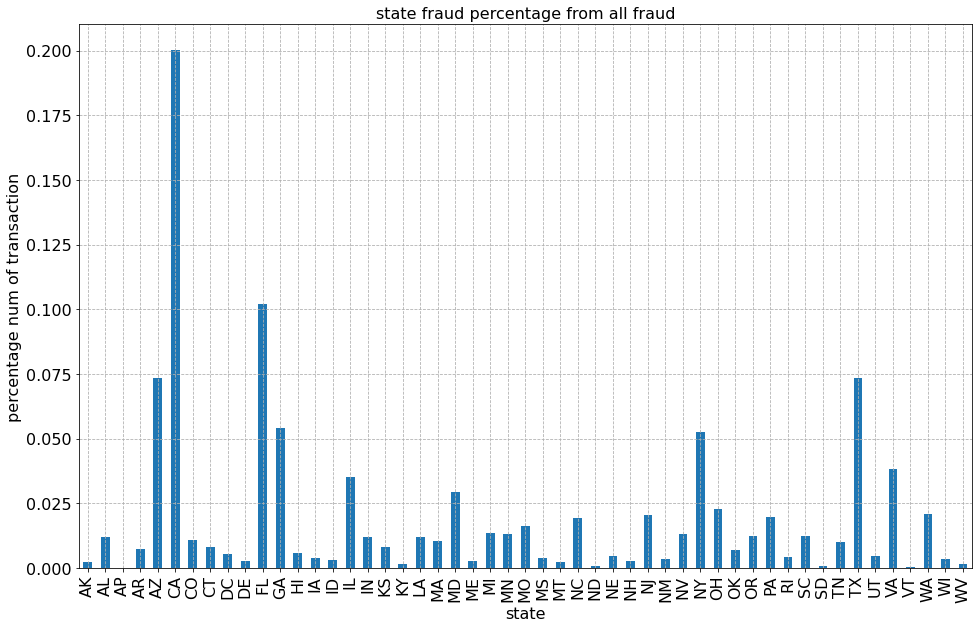

In [ ]:
df = df_train.loc[df_train['is_fraud'] == 1, ['state1', 'is_fraud']].groupby('state1').size()
df = df/df.sum()

fig, ax = plt.subplots(figsize=(16,10))
ax = df.plot(kind='bar', xlabel="state", ylabel="percentage num of transaction", title="state fraud percentage from all fraud")
ax.grid( linestyle='--')

CA state has the highest percentage in transactions fraud.

## Transaction Fraud in State

In [ ]:
df = df_train.loc[df_train['is_fraud'] == 1, ['domain1', 'is_fraud']].groupby('domain1').size().sort_values(ascending = False)
df = df/df.sum()
print('all percentage')
print(df)

all percentage
domain1
AOL.COM           0.215855
YAHOO.COM         0.160830
HOTMAIL.COM       0.120132
MSN.COM           0.043988
COMCAST.NET       0.031306
                    ...   
OFELNFGE.COM      0.000053
OFWGBTI.COM       0.000053
OLGZEAUP.COM      0.000053
OOOJSWTWVJ.COM    0.000053
MYACTV.NET        0.000053
Length: 757, dtype: float64


In [ ]:
df = df_train.loc[df_train['is_fraud'] == 1, ['domain1', 'is_fraud']].groupby('domain1').size()
df = df / df_train.groupby('domain1').size()
df = df.fillna(0).sort_values(ascending = False)
df = pd.concat([df.rename('fraud_percentage'), df_train.groupby('domain1').size().rename('count_all_email')], axis=1)
print('domain percentage')
print(df.sort_values(by='count_all_email', ascending = False))

domain percentage
                      fraud_percentage  count_all_email
AOL.COM                       0.027477           148049
YAHOO.COM                     0.021296           142326
HOTMAIL.COM                   0.021791           103896
MSN.COM                       0.022862            36261
COMCAST.NET                   0.016732            35262
...                                ...              ...
FVVIZELRTNQDUBW.NET           0.000000                9
FUUDBPF.COM                   0.000000                9
FUVDVQ.COM                    0.000000                9
FVBURAIXKEUZOBJH.COM          0.000000                9
MROEUO.COM                    0.000000                9

[9809 rows x 2 columns]


## Field Correlation

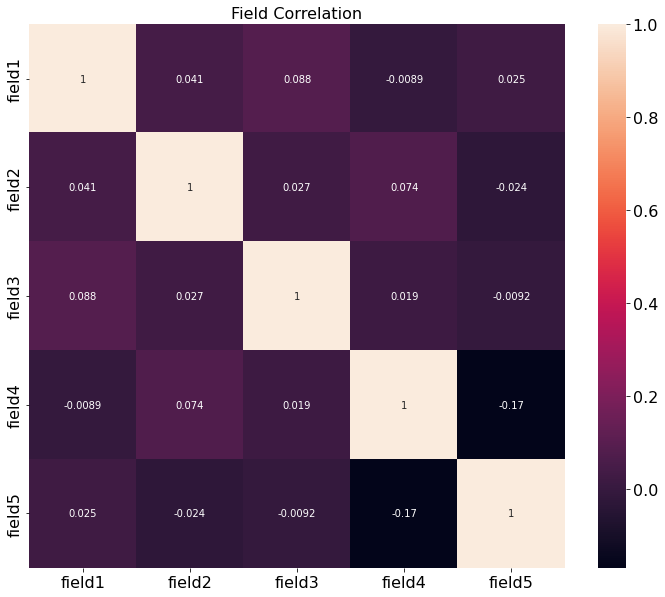

In [ ]:
df = df_train[['field1','field2','field3','field4','field5']]

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Field Correlation')
plt.show()

Field attributes have very weak correlation with other field attributes.

## Flag Correlation

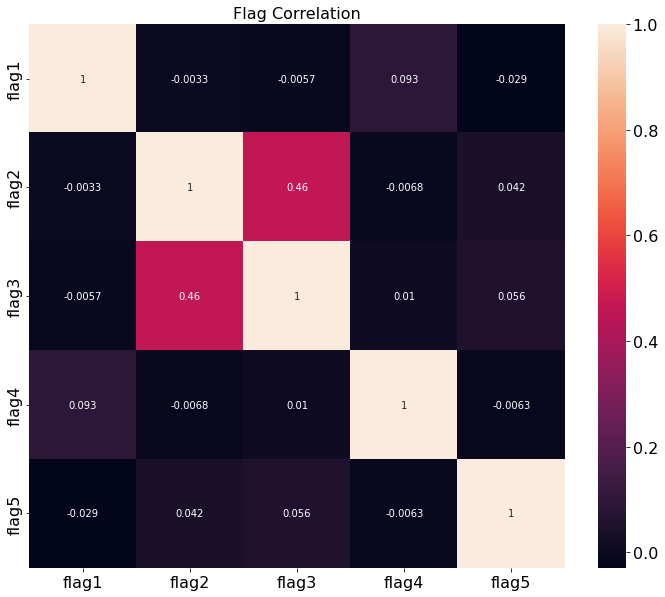

In [ ]:
df = df_train[['flag1','flag2','flag3','flag4','flag5']]

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Flag Correlation')
plt.show()

Flag attributes have very weak correlation with other flag attributes.

## Indicator Correlation

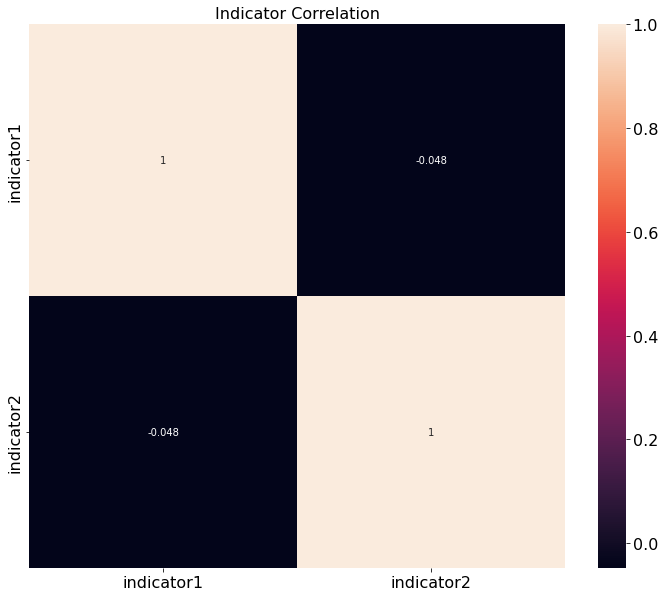

In [ ]:
df = df_train[['indicator1','indicator2']]

fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Indicator Correlation')
plt.show()

Indicator attributes have very weak correlation with other indicator attributes.

# Data Preprocessing